In [1]:
%reset -f
import time
t_start = time.time()

In [2]:
import sys
import os

# Verify the path
qe_path = "../../qe"
print(f"Adding {qe_path} to sys.path")
sys.path.insert(0, qe_path)

import my_cmaps

import numpy as np
import pandas as pd
import uproot
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

Adding ../../qe to sys.path
Welcome to JupyROOT 6.28/04


In [9]:
!ls /root/data/ggm_truth_analysis/madgraph_dump/CutTruthChannels

504669_analyze.root


In [10]:
# designates the data path
DSID = 345324
# DSID = 504669
TREES = str(DSID) + ";1"
if DSID == 345324:
    TYPE = "powheg"
elif DSID == 504669:
    TYPE = "madgraph"
PATH = f"/root/data/ggm_truth_analysis/{TYPE}_dump/"

# some constant
GEV = 1e-3
WORKERS = 64

In [11]:
def load_data(path=PATH, cut_stage="CutTruthTopo"):
    file = uproot.open(path + cut_stage + f"/{DSID}_analyze.root")
    branches = file[TREES].keys()
    data = {
        branch.split(".")[-1]: file[TREES][branch].array(library="pd")
        for branch in branches
    }
    print(branches)
    return data

In [12]:
data_truth = load_data(cut_stage="CutTruthChannels")

FileNotFoundError: file not found

    '/root/data/ggm_truth_analysis/powheg_dump/CutTruthChannels/345324_analyze.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [ ]:
data_truth["TruthCandLep1M"].describe()

count    1.035893e+06
mean     5.320685e+01
std      5.257439e+01
min      5.109429e-01
25%      5.110000e-01
50%      1.056600e+02
75%      1.056600e+02
max      1.056600e+02
dtype: float64

In [ ]:
threadshold = -9999
mask = (data_truth["TruthQEWpM"] > threadshold) & (data_truth["TruthQEWnM"] > threadshold) & (data_truth["TruthQEHM"] > threadshold)

In [ ]:
# truth stage leptons
# loading data

truth_lead_lep = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in [
                "TruthCandLep0Px",
                "TruthCandLep0Py",
                "TruthCandLep0Pz",
                "TruthCandLep0E",
            ]
        ]
    ).T
)[mask]
truth_sublead_lep = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in [
                "TruthCandLep1Px",
                "TruthCandLep1Py",
                "TruthCandLep1Pz",
                "TruthCandLep1E",
            ]
        ]
    ).T
)[mask]

# truth stage Ws
truth_w_ptruth = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in ["TruthQEWpPx", "TruthQEWpPy", "TruthQEWpPz", "TruthQEWpE"]
        ]
    ).T
)[mask]
truth_w_neg = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in ["TruthQEWnPx", "TruthQEWnPy", "TruthQEWnPz", "TruthQEWnE"]
        ]
    ).T
)[mask]

In [ ]:
data_truth["TruthQEWpM"][mask].describe()

count    1.035893e+06
mean     5.748935e+04
std      3.451215e+04
min     -1.801639e+02
25%      6.584754e-01
50%      7.880141e+04
75%      8.047495e+04
max      1.029247e+05
dtype: float64

(1035893,)


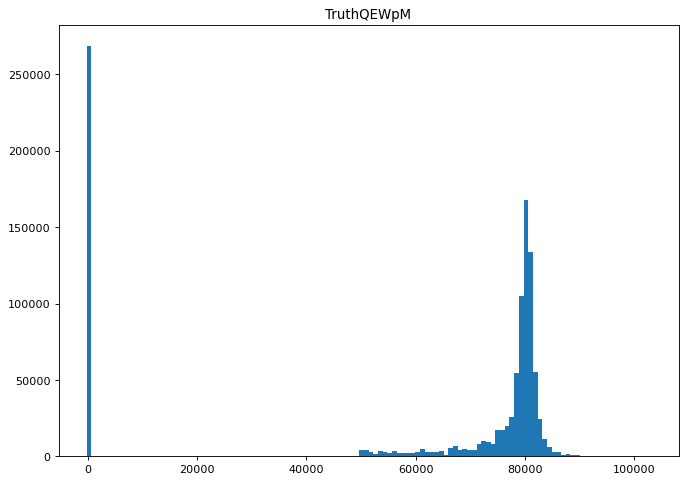

(1035893,)


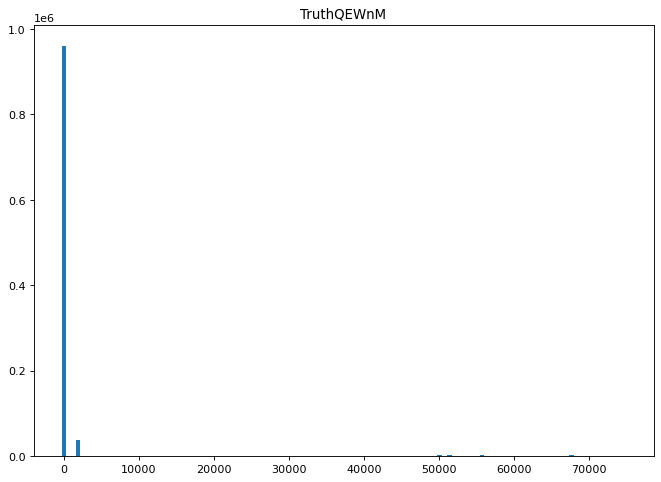

In [ ]:
#  TEST
print(data_truth["TruthQEWpM"][mask].shape)
fiugre = plt.figure(figsize=(10, 7), dpi=80)
plt.hist(data_truth["TruthQEWpM"][mask], bins=120)
plt.title("TruthQEWpM")
plt.show()
plt.close()
print(data_truth["TruthQEWnM"][mask].shape)
fiugre = plt.figure(figsize=(10, 7), dpi=80)
plt.hist(data_truth["TruthQEWnM"][mask], bins=120)
plt.title("TruthQEWnM")
plt.show()
plt.close()


In [ ]:
# main algorithm


def cglmp(z_xp, z_xn, z_yp, z_yn):
    """
    This is a function to calculate Bij (CGLMP values).
    :param z_xp: Angle (xi) between positive lepton and x-axis.
    :param z_xn: Angle (xi) between negative lepton and x-axis.
    :param z_yp: Angle (xi) between positive lepton and y-axis.
    :param z_xn: Angle (xi) between negative lepton and y-axis.
    """
    # count expectation value, use (27) in Alan's paper
    tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
    tr_b = (
        25 * (np.square(z_xp) - np.square(z_yp)) * (np.square(z_xn) - np.square(z_yn))
    )
    tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
    tr = tr_a + tr_b + tr_c

    return tr


def main_alg(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
    )

In [ ]:
# declare a generator for the resuts


def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    result = np.array((particles.shape[0], 3, 5))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(main_alg, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
    )

In [ ]:
# calculate results

# truth stage
truth_particles = np.concatenate(
    [truth_w_ptruth, truth_lead_lep, truth_w_neg, truth_sublead_lep], axis=1
)
truth_bij, truth_xi_pos, truth_xi_neg, truth_ggm_pos, truth_ggm_neg, truth_mask = result_generator(
    truth_particles
)

/tmp/ipykernel_1626912/2506733917.py:79: RuntimeWarning: invalid value encountered in divide
  cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
/tmp/ipykernel_1626912/2506733917.py:80: RuntimeWarning: invalid value encountered in divide
  cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
/tmp/ipykernel_1626912/2506733917.py:81: RuntimeWarning: invalid value encountered in divide
  cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)
/tmp/ipykernel_1626912/2506733917.py:94: RuntimeWarning: invalid value encountered in divide
  ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)
/tmp/ipykernel_1626912/2506733917.py:79: RuntimeWarning: invalid value encountered in divide
  cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
/tmp/ipykernel_1626912/2506733917.py:81: RuntimeWarning: invalid value encountered in divide
  cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)
/tmp/ipykernel_1626912/2506733917.py:80: RuntimeWarning: invalid value encountered in divide
 

In [ ]:
# 8 Wigner P-symbols angular functions


def P1(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.cos(phi)


def P2(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.sin(phi)


def P3(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 0.25 * (c * 4 * np.cos(theta) + 15 * np.cos(2 * theta) + 5)


def P4(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.cos(2 * phi)


def P5(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.sin(2 * phi)


def P6(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.cos(phi)


def P7(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.sin(phi)


def P8(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(1 / 48) * (c * 12 * np.cos(theta) - 15 * np.cos(2 * theta) - 5)

In [ ]:
def compute_Wigner(Phi_func: callable, angles: tuple, sign: str) -> np.float64:
    """
    Compute Wigner function for given angles and sign.
    """
    theta_0toPi, phi_0to2Pi = angles
    return Phi_func(theta_0toPi, phi_0to2Pi, sign)


def C_matrix(lp_theta, lp_phi, ln_theta, ln_phi):
    # Adjust angles to the paper requiring
    lp_theta_0toPi = np.where(lp_theta < 0, np.pi + lp_theta, lp_theta)
    ln_theta_0toPi = np.where(ln_theta < 0, np.pi + ln_theta, ln_theta)
    lp_phi_0to2Pi = np.where(lp_phi < 0, 2 * np.pi + lp_phi, lp_phi)
    ln_phi_0to2Pi = np.where(ln_phi < 0, 2 * np.pi + ln_phi, ln_phi)

    PSymb = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
    Phi_functions = [P1, P2, P3, P4, P5, P6, P7, P8]

    # Compute Wigner functions
    WignerPp_results = [
        compute_Wigner(Phi, (lp_theta_0toPi, lp_phi_0to2Pi), "pos")
        for Phi in Phi_functions
    ]
    WignerPn_results = [
        compute_Wigner(Phi, (ln_theta_0toPi, ln_phi_0to2Pi), "neg")
        for Phi in Phi_functions
    ]

    # Construct DataFrames from results
    WignerPp = pd.DataFrame(
        {PSymb[i] + "+": result for i, result in enumerate(WignerPp_results)}
    )
    WignerPn = pd.DataFrame(
        {PSymb[i] + "-": result for i, result in enumerate(WignerPn_results)}
    )

    # Compute C matrix using vectorized operations
    C = np.zeros((9, 9))
    C[0, 1:] = WignerPp.mean() * 0.5
    C[1:, 0] = WignerPn.mean() * 0.5
    for i in range(8):
        for j in range(8):
            C[i + 1, j + 1] = np.mean(WignerPn.iloc[:, i] * WignerPp.iloc[:, j]) * 0.25

    return C, WignerPp, WignerPn

In [ ]:
# retrieve elements from P-symbol Phi functions

# truth stage
truth_phi_pos, truth_phi_neg = truth_ggm_pos[:, 1], truth_ggm_neg[:, 1]
truth_theta_pos, truth_theta_neg = truth_ggm_pos[:, 2], truth_ggm_neg[:, 2]

In [ ]:
# calculate C matrix and Wigner P-symbol functions

truth_C, _, _ = C_matrix(truth_theta_pos, truth_phi_pos, truth_theta_neg, truth_phi_neg)

In [ ]:
def ggm_plot(C, title="RAW"):
    fig, ax = plt.subplots(figsize=(7, 7), dpi=120)
    xx, yy = np.meshgrid(np.arange(9), np.arange(9))
    im = ax.pcolormesh(
        xx,
        yy,
        C,
        cmap=my_cmaps.hotcold(neutral=1.0),
        vmin=-0.25,
        vmax=0.25,
        shading="auto",
    )
    ax.set_aspect(1)
    # Remove the tick lines
    ax.tick_params(axis="both", which="minor", tick1On=False, tick2On=False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation="vertical")
    ticks = np.arange(-0.25, 0.26, 0.05)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_verticalalignment("center")
    for label in ax.get_yticklabels(minor=True):
        label.set_horizontalalignment("center")
    ax.set_xticks(np.arange(9))
    ax.set_xlabel(r"$W^{+}$ GM index", fontsize=12)
    ax.set_ylabel(r"$W^{-}$ GM index", fontsize=12)
    ax.set_title(f"{title} " + r"$pp\to H \to WW^* \to \ell \nu \ell \nu$", fontsize=16)
    plt.show()
    plt.close()

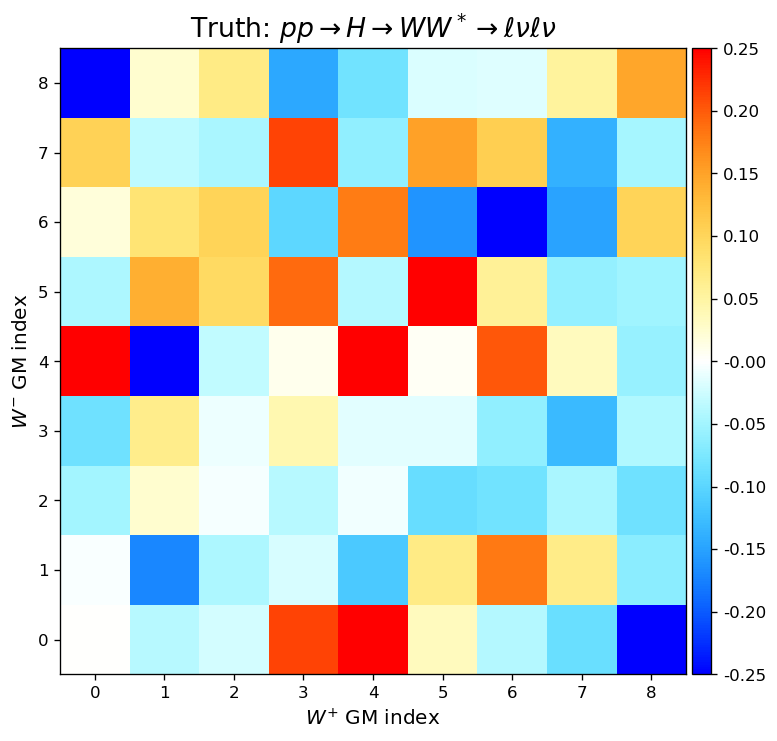

In [ ]:
# raw
ggm_plot(truth_C, "Truth:")

In [ ]:
t_end = time.time()
print(f"Total spending time: {t_end-t_start: .2f} (s)")

Total spending time:  551.64 (s)
